In [114]:
# Data handling
import pandas as pd
import numpy as np
import re

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning Models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import LabelEncoder
from scipy.stats.mstats import winsorize
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

# Warnings
import warnings
warnings.filterwarnings("ignore")

### Step 1: Data Preparation

In [4]:
df = pd.read_csv(r"C:\Users\User\Desktop\Portfolio Projects\Home Credit Risk\credit_risk_dataset.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB


#### Duplicate

In [6]:
# Check for duplicate rows in the dataset
duplicate_rows = df.duplicated().sum()

# Display the number of duplicate rows
print(f"Number of duplicate rows: {duplicate_rows}")

Number of duplicate rows: 165


In [8]:
# Remove duplicates 
df = df.drop_duplicates()
duplicate_rows1 = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_rows1}")

Number of duplicate rows: 0


#### Missing Values

In [10]:
# Check missing values
missing_values = df.isnull().sum().sort_values(ascending=False)
missing_values = missing_values[missing_values > 0]
print("Missing values per column:\n", missing_values)

Missing values per column:
 loan_int_rate        3095
person_emp_length     887
dtype: int64


In [12]:
# Median Imputation for numerical columns
df['loan_int_rate'].fillna(df['loan_int_rate'].median(), inplace=True)
df['person_emp_length'].fillna(df['person_emp_length'].median(), inplace=True)

# Verify no missing values remain
missing_values = df.isnull().sum()
print("Missing values after imputation:\n", missing_values[missing_values > 0])


Missing values after imputation:
 Series([], dtype: int64)


#### Outliers

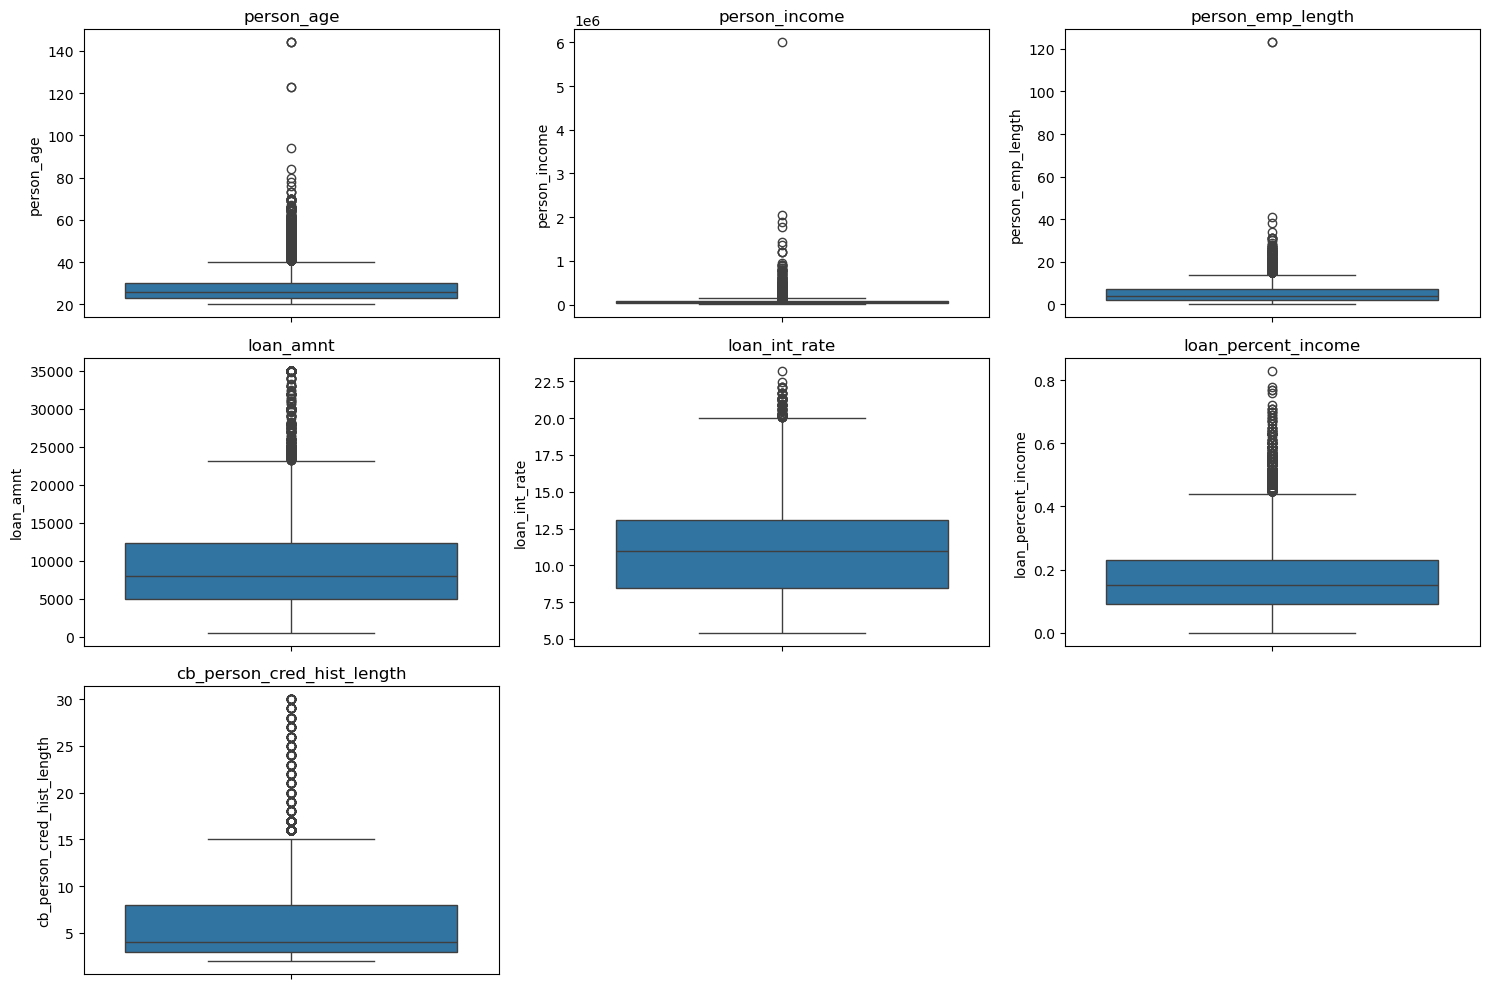

In [21]:
# Select numerical features except 'loan_status'
numerical_features = ['person_age', 'person_income', 'person_emp_length', 
                      'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length']

# Set up the plot
plt.figure(figsize=(15, 10))

# Create boxplots for each numerical feature
for i, col in enumerate(numerical_features, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(y=df[col])
    plt.title(col)

plt.tight_layout()
plt.show()

In [23]:
# Select numerical features excluding 'loan_status'
numerical_features = ['person_age', 'person_income', 'person_emp_length', 
                      'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length']

# Calculate skewness
skewness_values = df[numerical_features].skew()

# Determine outlier handling method based on skewness
def outlier_method(skew):
    if -0.5 <= skew <= 0.5:
        return "IQR"
    elif -1 <= skew < -0.5 or 0.5 < skew <= 1:
        return "Winsorization"
    else:
        return "Log Transformation"

# Create a DataFrame to display results
skewness_df = pd.DataFrame({
    "Feature": numerical_features,
    "Skewness": skewness_values.values,
    "Outlier Handling Method": [outlier_method(skew) for skew in skewness_values.values]
})

# Display the dataframe
from IPython.display import display
display(skewness_df)

,Feature,Skewness,Outlier Handling Method
0,person_age,2.580490,Log Transformation
1,person_income,32.958748,Log Transformation
2,person_emp_length,2.668217,Log Transformation
3,loan_amnt,1.191944,Log Transformation
4,loan_int_rate,0.220183,IQR
5,loan_percent_income,1.063811,Log Transformation
6,cb_person_cred_hist_length,1.659369,Log Transformation


In [25]:
# Log Transformation for highly skewed features
log_transform_features = [
    "person_age", "person_income", "person_emp_length", 
    "loan_amnt", "loan_percent_income", "cb_person_cred_hist_length"
]

for col in log_transform_features:
    df[col] = np.log1p(df[col])  # log1p to handle zeros safely

# IQR Method for moderately skewed feature (loan_int_rate)
def remove_outliers_iqr(data, col):
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data[(data[col] >= lower_bound) & (data[col] <= upper_bound)]

df = remove_outliers_iqr(df, "loan_int_rate")

# Verify changes
print("Outliers handled successfully!")

Outliers handled successfully!


### Step 2: Feature Engineering

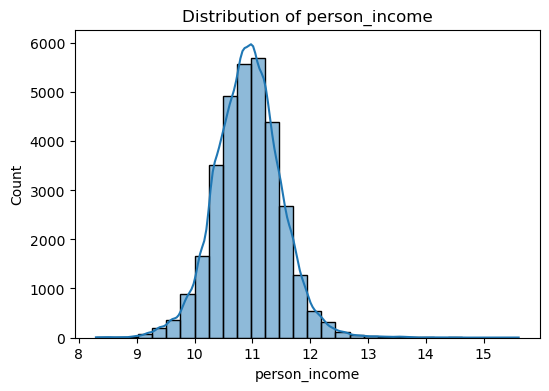

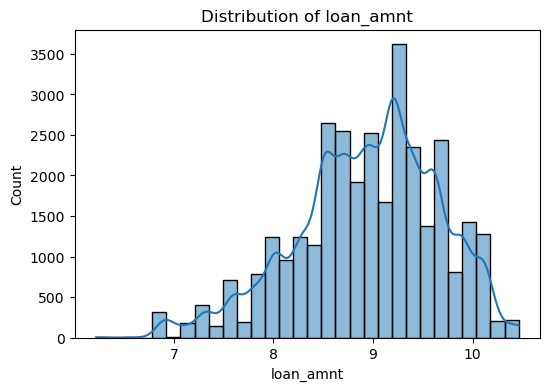

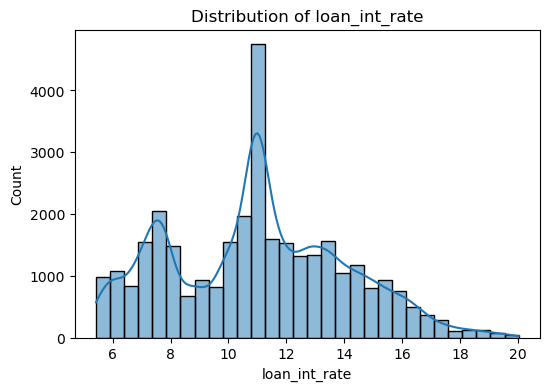

In [28]:
for col in ["person_income", "loan_amnt", "loan_int_rate"]:
    plt.figure(figsize=(6,4))
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f"Distribution of {col}")
    plt.show()

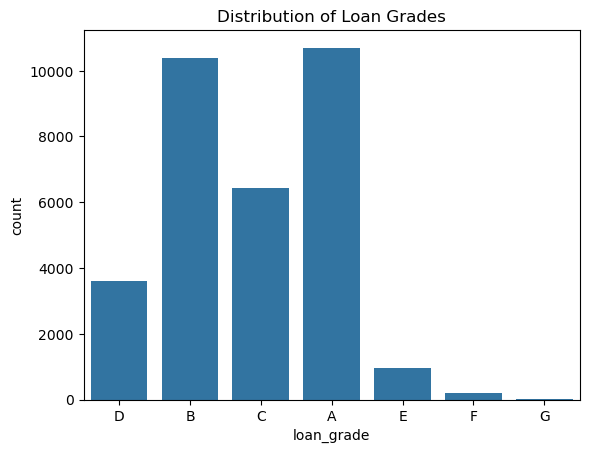

In [32]:
sns.countplot(x=df["loan_grade"])
plt.title("Distribution of Loan Grades")
plt.show()

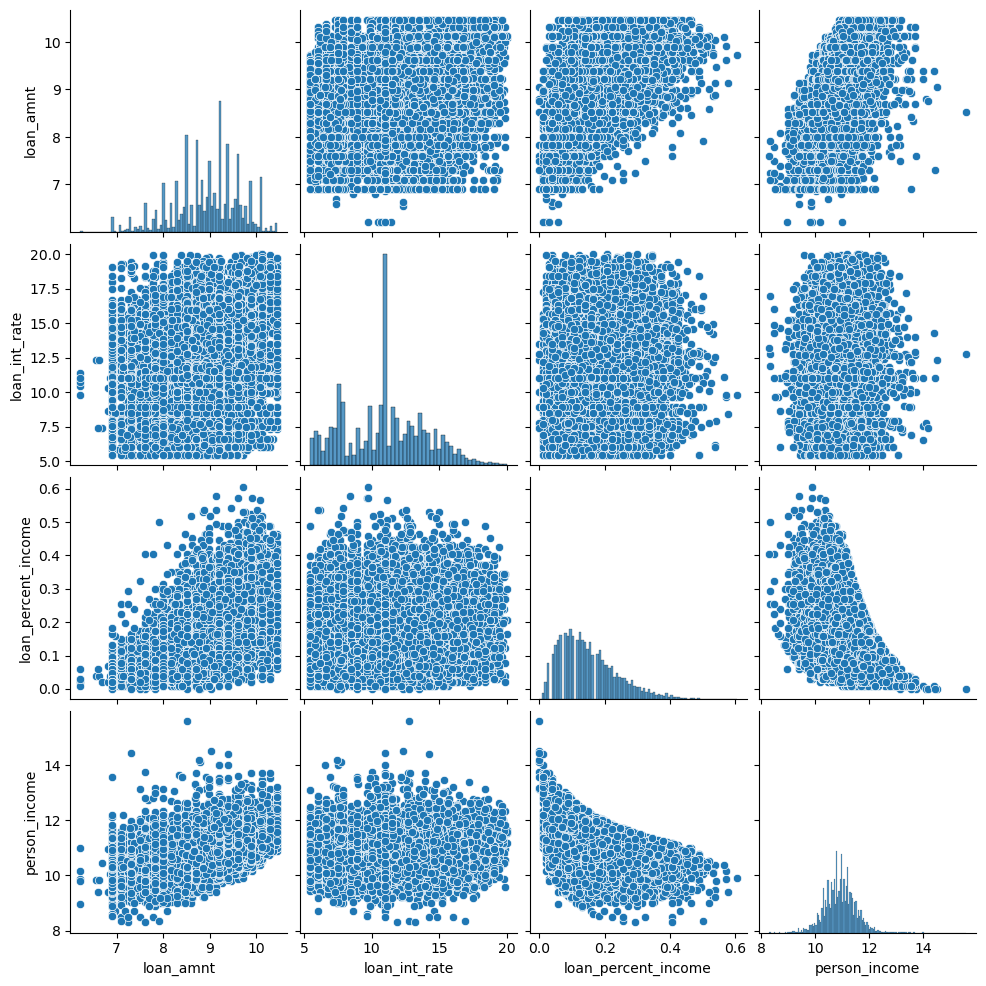

In [36]:
sns.pairplot(df[["loan_amnt", "loan_int_rate", "loan_percent_income", "person_income"]])
plt.show()

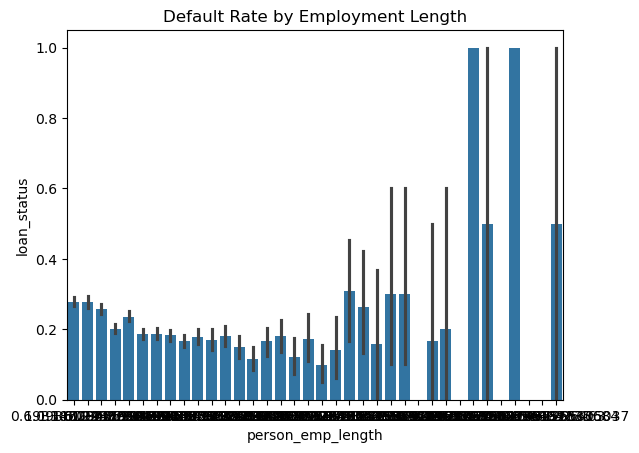

In [38]:
sns.barplot(x="person_emp_length", y="loan_status", data=df)
plt.title("Default Rate by Employment Length")
plt.show()

In [40]:
# Separate target variable (loan_status) from features
X = df.drop(columns=["loan_status"])  # Feature variables
y = df["loan_status"]  # Target variable

# Verify separation
print("Features (X) Shape:", X.shape)
print("Target (y) Shape:", y.shape)


Features (X) Shape: (32346, 11)
Target (y) Shape: (32346,)


In [42]:
# Identify numerical features (excluding the target variable)
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Identify categorical features
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

# Display results
print("Numerical Features:", numerical_features)
print("Categorical Features:", categorical_features)


Numerical Features: ['person_age', 'person_income', 'person_emp_length', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length']
Categorical Features: ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']


In [44]:
# Define ordinal features based on known order
ordinal_features = {
    "loan_grade": ["A", "B", "C", "D", "E", "F", "G"]  # Assuming loan grades follow a ranking
}

# Identify categorical features
nominal_features = []
ordinal_features_list = []

for col in categorical_features:
    if col in ordinal_features:
        ordinal_features_list.append(col)
    else:
        nominal_features.append(col)

# Display results
print("Ordinal Features:", ordinal_features_list)
print("Nominal Features:", nominal_features)


Ordinal Features: ['loan_grade']
Nominal Features: ['person_home_ownership', 'loan_intent', 'cb_person_default_on_file']


In [46]:
# Label Encoding for Ordinal Feature (loan_grade)
ordinal_mapping = {"A": 1, "B": 2, "C": 3, "D": 4, "E": 5, "F": 6, "G": 7}
df["loan_grade"] = df["loan_grade"].map(ordinal_mapping)

# One-Hot Encoding for Nominal Features
nominal_features = ["person_home_ownership", "loan_intent", "cb_person_default_on_file"]
df = pd.get_dummies(df, columns=nominal_features, drop_first=True)  # drop_first=True avoids dummy variable trap

# Display transformed dataset
print("Encoding completed successfully!")
df.head()

Encoding completed successfully!


,person_age,person_income,person_emp_length,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length,person_home_ownership_OTHER,person_home_ownership_OWN,person_home_ownership_RENT,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,cb_person_default_on_file_Y
0,3.135494,10.985310,4.820282,4,10.463132,16.02,1,0.463734,1.386294,False,False,True,False,False,False,True,False,True
1,3.091042,9.169623,1.791759,2,6.908755,11.14,0,0.095310,1.098612,False,True,False,True,False,False,False,False,False
2,3.258097,9.169623,0.693147,3,8.612685,12.87,1,0.451076,1.386294,False,False,False,False,False,True,False,False,False
3,3.178054,11.089821,1.609438,3,10.463132,15.23,1,0.425268,1.098612,False,False,True,False,False,True,False,False,False
4,3.218876,10.904138,2.197225,3,10.463132,14.27,1,0.438255,1.609438,False,False,True,False,False,True,False,False,True


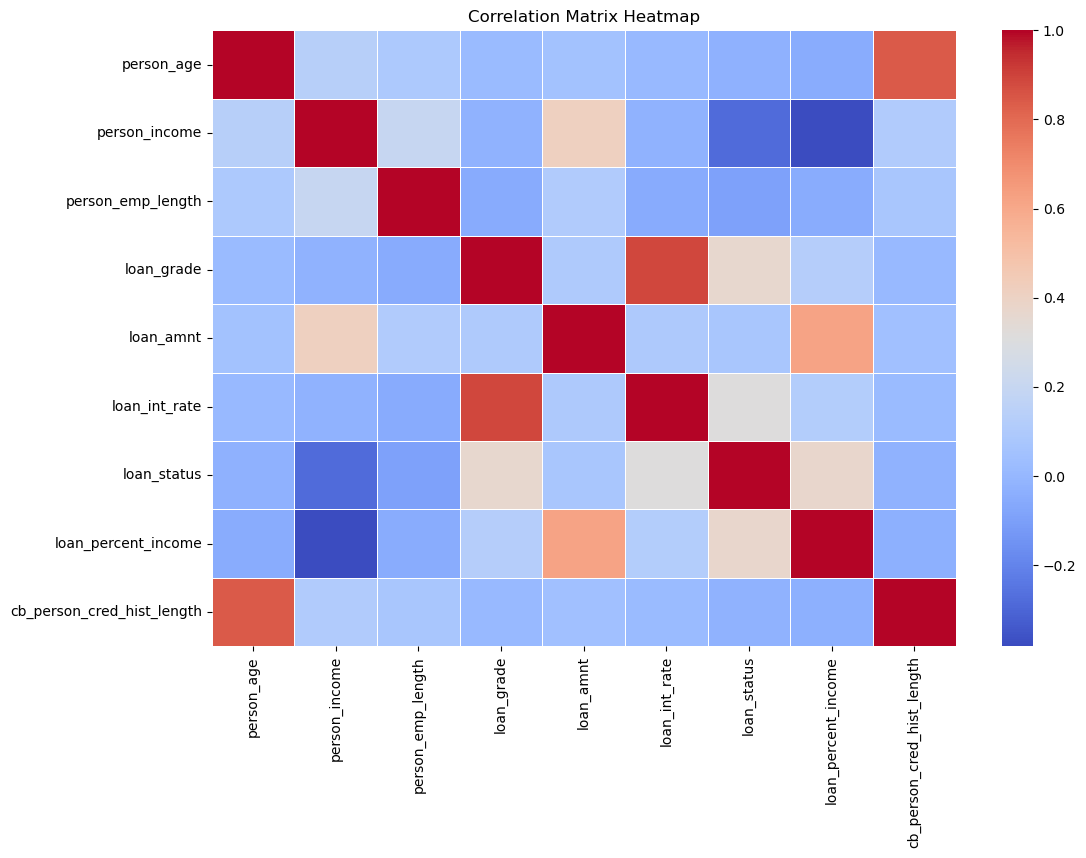

In [48]:
# Ensure all columns are numeric before computing correlation
df_numeric = df.select_dtypes(include=['number'])

# Compute correlation matrix
correlation_matrix = df_numeric.corr()

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=False, cmap="coolwarm", linewidths=0.5)

# Title for the heatmap
plt.title("Correlation Matrix Heatmap")
plt.show()

In [58]:
# Import necessary libraries
from sklearn.feature_selection import mutual_info_classif

# Ensure X contains only numerical features
X_numeric = X.select_dtypes(include=['number'])

# Train a RandomForestClassifier to get feature importance
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_numeric, y)
rf_importances = rf.feature_importances_

# Compute Mutual Information scores (fix: ensure proper import)
mi_scores = mutual_info_classif(X_numeric, y)

# Create a DataFrame for comparison
feature_importance_df = pd.DataFrame({
    "Feature": X_numeric.columns,
    "RandomForest Importance": rf_importances,
    "Mutual Information": mi_scores
})

# Sort by importance
feature_importance_df = feature_importance_df.sort_values(by="RandomForest Importance", ascending=False)

# Display results
display(feature_importance_df)


,Feature,RandomForest Importance,Mutual Information
5,loan_percent_income,0.234480,0.080752
4,loan_int_rate,0.232970,0.068025
1,person_income,0.213546,0.110862
3,loan_amnt,0.109881,0.013764
2,person_emp_length,0.077330,0.003522
0,person_age,0.072957,0.007072
6,cb_person_cred_hist_length,0.058837,0.000000


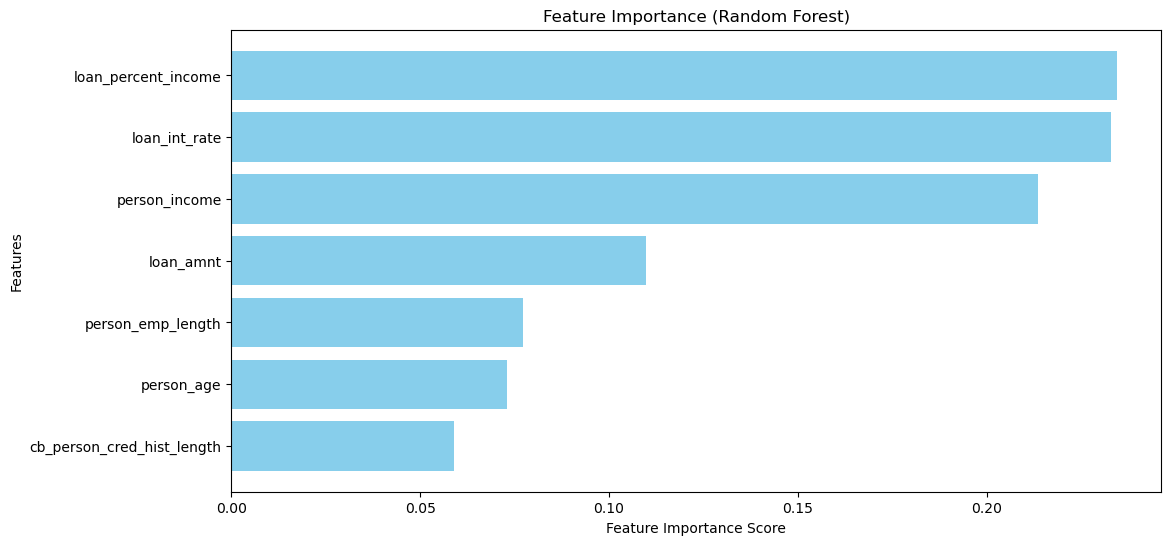

In [56]:
# Plot feature importance as a horizontal bar chart
plt.figure(figsize=(12, 6))
plt.barh(feature_importance_df["Feature"], feature_importance_df["RandomForest Importance"], color="skyblue")
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.title("Feature Importance (Random Forest)")
plt.gca().invert_yaxis()  # Invert y-axis to show the most important feature on top
plt.show()

In [78]:
# Drop the least important feature
X = X.drop(columns=["cb_person_cred_hist_length"])

# Confirm feature removal
print("Updated Feature Set:", X.columns)


Updated Feature Set: Index(['person_age', 'person_income', 'person_emp_length', 'loan_grade',
       'loan_amnt', 'loan_int_rate', 'loan_percent_income',
       'person_home_ownership_OTHER', 'person_home_ownership_OWN',
       'person_home_ownership_RENT', 'loan_intent_EDUCATION',
       'loan_intent_HOMEIMPROVEMENT', 'loan_intent_MEDICAL',
       'loan_intent_PERSONAL', 'loan_intent_VENTURE',
       'cb_person_default_on_file_Y'],
      dtype='object')


#### Analyze Feeature Distribution to apply Standardization or Normalization
##### Standardization (Z-score scaling) for normally distributed features.
##### Normalization for skewed features.

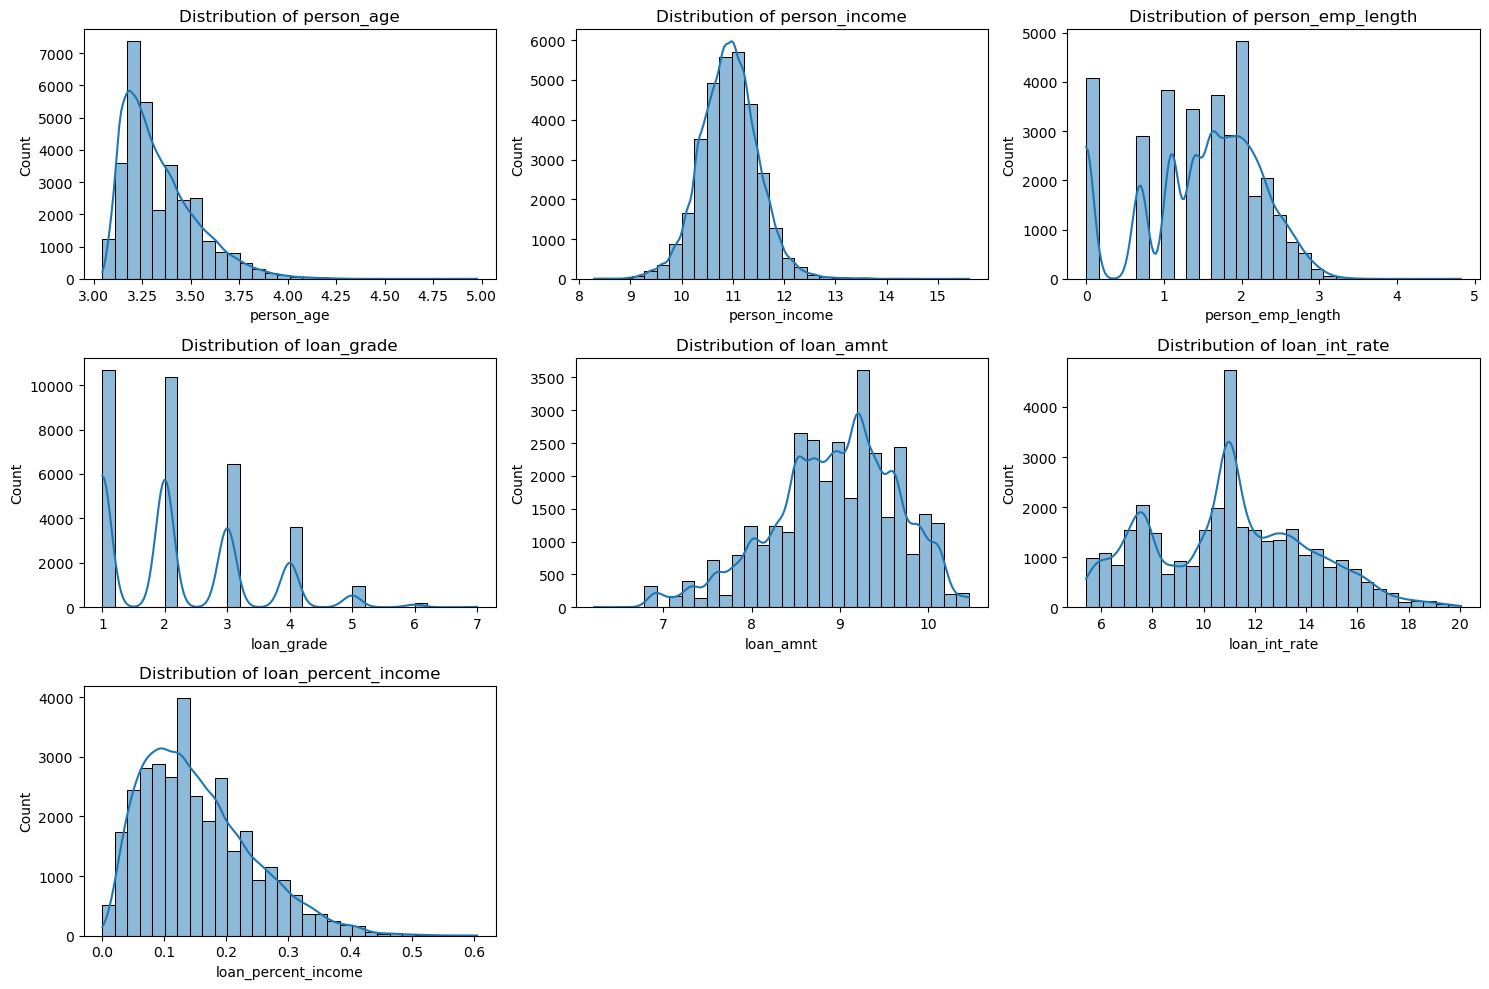

In [80]:
# Select numerical features
numerical_features = X.select_dtypes(include=['number']).columns

# Plot distribution of each numerical feature
plt.figure(figsize=(15, 10))

for i, col in enumerate(numerical_features, 1):
    plt.subplot(3, 3, i)
    sns.histplot(X[col], kde=True, bins=30)
    plt.title(f"Distribution of {col}")

plt.tight_layout()
plt.show()


In [84]:
# Standardization (Z-score) for normally distributed features
standardize_cols = ["person_income", "loan_int_rate"]
scaler_standard = StandardScaler()
X[standardize_cols] = scaler_standard.fit_transform(X[standardize_cols])

# Normalization (Min-Max) for skewed features
normalize_cols = ["person_age", "person_emp_length", "loan_amnt", "loan_percent_income"]
scaler_minmax = MinMaxScaler()
X[normalize_cols] = scaler_minmax.fit_transform(X[normalize_cols])

# Display transformed dataset
print("Feature scaling completed successfully!")
X.head()

Feature scaling completed successfully!


,person_age,person_income,person_emp_length,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,person_home_ownership_OTHER,person_home_ownership_OWN,person_home_ownership_RENT,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,cb_person_default_on_file_Y
0,0.047082,0.105764,1.000000,4,1.000000,1.647167,0.767370,False,False,True,False,False,False,True,False,True
1,0.024076,-3.103983,0.371713,2,0.162992,0.048073,0.157716,False,True,False,True,False,False,False,False,False
2,0.110534,-3.103983,0.143798,3,0.564245,0.614965,0.746423,False,False,False,False,False,True,False,False,False
3,0.069108,0.290517,0.333889,3,1.000000,1.388297,0.703718,False,False,True,False,False,True,False,False,False
4,0.090235,-0.037731,0.455829,3,1.000000,1.073721,0.725208,False,False,True,False,False,True,False,False,True


### Step 4: Train-Test Splitting & Data Balancing

In [72]:
# Ensure X and y are correctly defined
X = df.drop(columns=["loan_status"])  # Features
y = df["loan_status"]  # Target variable

# Split the data into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Display dataset shapes
print(f"Training Features Shape: {X_train.shape}")
print(f"Testing Features Shape: {X_test.shape}")
print(f"Training Target Shape: {y_train.shape}")
print(f"Testing Target Shape: {y_test.shape}")


Training Features Shape: (25876, 17)
Testing Features Shape: (6470, 17)
Training Target Shape: (25876,)
Testing Target Shape: (6470,)


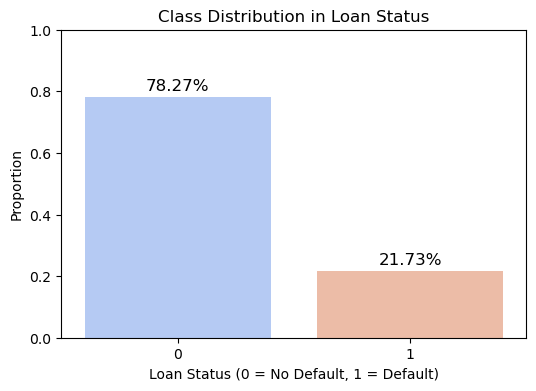

loan_status
0    0.782662
1    0.217338
Name: proportion, dtype: float64


In [74]:
# Check class distribution in the target variable
class_counts = y.value_counts(normalize=True)  # Get proportion of each class

# Plot class distribution
plt.figure(figsize=(6,4))
sns.barplot(x=class_counts.index, y=class_counts.values, palette="coolwarm")
plt.xlabel("Loan Status (0 = No Default, 1 = Default)")
plt.ylabel("Proportion")
plt.title("Class Distribution in Loan Status")
plt.ylim(0, 1)  # Set y-axis limit to show proportions clearly

# Display the proportion values
for i, v in enumerate(class_counts.values):
    plt.text(i, v + 0.02, f"{v:.2%}", ha='center', fontsize=12)

plt.show()

# Print class distribution
print(class_counts)

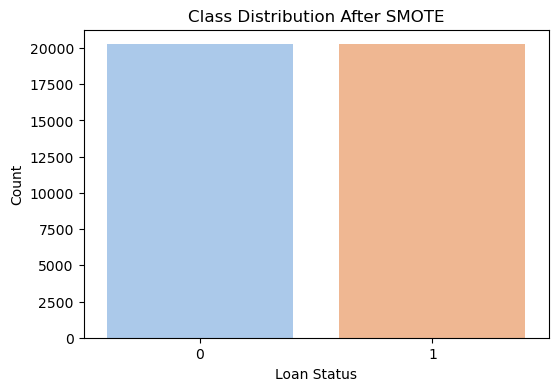

New Class Distribution After SMOTE:
loan_status
0    0.5
1    0.5
Name: proportion, dtype: float64


In [76]:
# Handle Class Imbalance using SMOTE

# Initialize SMOTE
smote = SMOTE(random_state=42)

# Apply SMOTE only to training data
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Visualize the new class distribution
plt.figure(figsize=(6,4))
sns.countplot(x=y_train_resampled, palette="pastel")
plt.title("Class Distribution After SMOTE")
plt.xlabel("Loan Status")
plt.ylabel("Count")
plt.show()

# Display the new class distribution
print("New Class Distribution After SMOTE:")
print(y_train_resampled.value_counts(normalize=True))

In [102]:
# Initialize models
log_reg = LogisticRegression(random_state=42)
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Train models
log_reg.fit(X_train_resampled, y_train_resampled)
rf_model.fit(X_train_resampled, y_train_resampled)
xgb_model.fit(X_train_resampled, y_train_resampled)

# Make predictions and evaluate models
models = {
    "Logistic Regression": log_reg,
    "Random Forest": rf_model,
    "XGBoost": xgb_model
}

results = {}

for name, model in models.items():
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    
    # Evaluate model performance
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob)
    
    results[name] = [accuracy, precision, recall, f1, roc_auc]

# Convert results to DataFrame for display
results_df = pd.DataFrame(results, index=["Accuracy", "Precision", "Recall", "F1 Score", "AUC-ROC"])

# Display the results
display(results_df)

,Logistic Regression,Random Forest,XGBoost
Accuracy,0.790417,0.927821,0.931839
Precision,0.511737,0.914387,0.939035
Recall,0.775249,0.736842,0.733997
F1 Score,0.616516,0.816069,0.823952
AUC-ROC,0.865639,0.931957,0.943109


In [104]:
# Find the best model based on AUC-ROC (can change criteria)
best_model = results_df.idxmax(axis=1)["AUC-ROC"]
best_model_score = results_df.loc["AUC-ROC"].max()

# Display best model
print(f"🏆 The best model is **{best_model}** with an AUC-ROC score of {best_model_score:.4f}.")


🏆 The best model is **XGBoost** with an AUC-ROC score of 0.9431.
